<a href="https://colab.research.google.com/github/R12942159/NTU_DLCV/blob/Hw3/p2_Visualization%20of%20Attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install timm

In [108]:
import os
import re
import math
import timm
import json
import torch
import collections
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torchvision.transforms as tr

from PIL import Image
from tqdm import tqdm
from pathlib import Path
from torch import nn, Tensor
from torch.utils.data import DataLoader
from torchvision.transforms.functional import resize

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using: {device}")

Using: cuda


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### Download dataset and unzip zip file.

In [ ]:
!gdown 1SUiRrG6zQVtyrVSVh9hOBq5_fX-oV2Lh -O hw3_data.zip # 11rP6KmR5Qwjhx0rfag0b5TZGBTRuPtQR
!unzip /content/hw3_data.zip

#### Tokenizer ('<|endoftext|>', 50256) -> 250dim

In [5]:
class BPETokenizer:

    def __init__(self, encoder_file, vocab_file):
        with open(encoder_file, 'r', encoding='utf-8') as f:
            self.encoder = json.load(f)
        self.decoder = {v:k for k,v in self.encoder.items()}
        with open(vocab_file, 'r', encoding='utf-8') as f:
            vocab = f.read().split('\n')[1:-1]
        self.bpe_ranks = {tuple(line.split()): i for i, line in enumerate(vocab)}
        assert len(self.encoder) == 50257 and len(self.bpe_ranks) == 49999 # len(self.bpe_ranks) == 50000
        bs = list(range(33, 127)) + list(range(161, 256))
        xs = list(range(0, 33)) + list(range(127, 161))
        cs = bs[:] + [2**8 + i for i in range(len(xs))]
        self.byte_encoder = dict(zip(bs + xs, [chr(n) for n in cs]))
        self.byte_decoder = {v:k for k, v in self.byte_encoder.items()}

    def encode(self, text, allowed_special=None):
        tokens = re.findall(r"""<\|endoftext\|>|'s|'t|'re|'ve|'m|'ll|'d| ?""" +
                            r"""\w+| ?\d+| ?[^\s\w\d]+|\s+(?!\S)|\s+""", text, re.UNICODE)
        def translate(token):
            if token == '<|endoftext|>':
                assert allowed_special and token in allowed_special
                return [token]
            word = tuple(''.join(self.byte_encoder[byte] for byte in token.encode('utf-8')))
            while len(word) != 1:
                pairs = set((word[i], word[i+1]) for i in range(len(word)-1))
                bigram = min(pairs, key = lambda pair: self.bpe_ranks.get(pair, float('inf')))
                if bigram not in self.bpe_ranks:
                    break
                a, b = bigram
                new_word = []
                i = 0
                while i < len(word):
                    j = word.index(a, i) if a in word[i:] else len(word)
                    new_word.extend(word[i:j])
                    i = j
                    if i < len(word):
                        j = 2 if i < len(word)-1 and word[i] == a and word[i+1] == b else 1
                        new_word.append(a+b if j == 2 else word[i])
                        i += j
                word = tuple(new_word)
            return word
        return [self.encoder[_] for token in tokens for _ in translate(token)]

    def decode(self, tokens):
        tokens = [self.decoder[token] for token in tokens]
        buffer = bytearray([self.byte_decoder[c] for c in ''.join(tokens)])
        return buffer.decode('utf-8', errors='replace')

In [17]:
encoding = BPETokenizer('/content/encoder.json', '/content/vocab.bpe')

#### Define function

In [6]:
def json_load(json_path: str):
    with open(json_path, 'r', encoding='utf-8') as file:
        data = json.load(file)
    return data

In [7]:
def caption_with_id(json_path: str) -> list:
    with open(json_path, 'r', encoding='utf-8') as file:
        json_data = json.load(file)
    data = [{'caption': row['caption'], 'image_id': row['image_id']} for row in json_data['annotations']]
    return data

In [8]:
def id2file_name(json_path: str) -> dict:
    with open(json_path, 'r', encoding='utf-8') as file:
        json_data = json.load(file)
    data = {row['id']: row['file_name'] for row in json_data['images']}
    return data

#### Build Dataset

In [9]:
class ImgDataset(torch.utils.data.Dataset):
    def __init__(self, root: str, transform) -> None:
        self.transform = transform
        self.img_path = [i for i in Path(root).glob("*.jpg")]

    def __len__(self) -> int:
        return len(self.img_path)

    def __getitem__(self, idx):
        img = Image.open(self.img_path[idx]).convert('RGB')
        img = self.transform(img)
        return img, os.path.splitext(self.img_path[idx].name)[0]

#### Build Dataloader

In [10]:
img_ds = ImgDataset(
    root='/content/hw3_data/p3_data/images',
    transform=tr.Compose([
        tr.Resize(224),
        tr.CenterCrop(224),
        tr.ToTensor(),
        tr.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]),
)

img_loader = DataLoader(
    img_ds,
    batch_size=1,
    shuffle=False,
    num_workers=4,
)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


#### Config

In [11]:
class Config:

    def __init__(self, checkpoint=None):
        self.n_layer = 12
        self.n_head = 12
        self.n_embd = 768
        self.vocab_size = 50257
        self.block_size = 1024
        self.checkpoint = checkpoint

In [12]:
cfg = Config(checkpoint='/content/hw3_data/p2_data/decoder_model.bin')

#### decoder

In [13]:
class Attention(nn.Module):

    def __init__(self, cfg):
        super().__init__()
        self.c_attn = nn.Linear(cfg.n_embd, 3 * cfg.n_embd)
        self.c_proj = nn.Linear(cfg.n_embd, cfg.n_embd)
        self.n_head = cfg.n_head
        self.n_embd = cfg.n_embd
        size = cfg.block_size
        self.register_buffer('bias', torch.tril(torch.ones(size, size)).view(1, 1, size, size))

    def forward(self, x):
        B, T, C = x.size() # batch, context, embedding
        q, k, v  = self.c_attn(x).split(self.n_embd, dim=2)
        k = k.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)
        q = q.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)
        v = v.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)
        att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
        att = att.masked_fill(self.bias[:,:,:T,:T] == 0, float('-inf'))
        att = F.softmax(att, dim=-1)
        return self.c_proj((att @ v).transpose(1, 2).contiguous().view(B, T, C))

class CrossAttention(nn.Module):

    def __init__(self, cfg):
        super().__init__()
        self.multihead_attn = nn.MultiheadAttention(cfg.n_embd, cfg.n_head, batch_first=True)

    def forward(self, query, encoder_out):
        """
        Q is the source from the decoder, K, V are the sources from the encoder.
        Q: (N, L, Eq), where L is the target embedding dim, Eq is embed_dim and batch_first=True.
        {K, V}: (N, L, E{k,v}), where L is the source embedding dim, E{k,v} is {k,v}_dim and batch_first=True.
        """
        attn_output, attn_output_weights = self.multihead_attn(query, encoder_out, encoder_out)
        return attn_output, attn_output_weights

class Block(nn.Module):

    def __init__(self, cfg):
        super().__init__()
        self.ln_1 = nn.LayerNorm(cfg.n_embd)
        self.ln_2 = nn.LayerNorm(cfg.n_embd) # add
        self.ln_3 = nn.LayerNorm(cfg.n_embd)
        self.attn = Attention(cfg)
        self.crs_attn = CrossAttention(cfg) # add
        self.mlp = nn.Sequential(collections.OrderedDict([
            ('c_fc', nn.Linear(cfg.n_embd, 4 * cfg.n_embd)),
            ('act', nn.GELU(approximate='tanh')),
            ('c_proj', nn.Linear(4 * cfg.n_embd, cfg.n_embd))
        ]))

    def forward(self, x, encoder_out) -> Tensor: # add
        x = x + self.attn(self.ln_1(x))
        cross_x, weights = self.crs_attn(self.ln_2(x), self.ln_2(encoder_out)) # add
        x = cross_x + x
        x = x + self.mlp(self.ln_3(x))
        return x, weights

class Decoder(nn.Module):

    def __init__(self, cfg):
        super().__init__()
        self.cfg = cfg
        self.block_size = cfg.block_size
        self.transformer = nn.ModuleDict(dict(
            wte = nn.Embedding(cfg.vocab_size, cfg.n_embd), # 文字投影
            wpe = nn.Embedding(cfg.block_size, cfg.n_embd), # position
            h = nn.Sequential(*[Block(cfg) for _ in range(cfg.n_layer)]), # Nx
            ln_f = nn.LayerNorm(cfg.n_embd)
        ))
        self.lm_head = nn.Linear(cfg.n_embd, cfg.vocab_size, bias=False)
        self.transformer.wte.weight = self.lm_head.weight
        # timm's ViT encoder (vit_base_patch16_224_in21k, , vit_huge_patch14_224_in21k)
        self.encoder = timm.create_model('vit_large_patch16_224_in21k', pretrained=True)
        self.linear = nn.Linear(1024, cfg.n_embd) # [16, 197, 1024]
        # load checkpoint
        if self.cfg.checkpoint is not None:
            state_dict = torch.load(self.cfg.checkpoint)
            transposed = [ '.c_attn.weight', '.c_fc.weight', '.c_proj.weight' ]
            for key, value in state_dict.items():
                if any(key.endswith(w) for w in transposed):
                    state_dict[key] = value.t()
            self.transformer.load_state_dict(state_dict, strict=False)

    def forward(self, x: Tensor, img: Tensor) -> Tensor: # add
        x = torch.narrow(x, 1, 0, min(x.size(1), self.block_size))
        pos = torch.arange(x.size()[1], dtype=torch.long, device=x.device).unsqueeze(0)
        x = self.transformer.wte(x) + self.transformer.wpe(pos)
        with torch.no_grad():
            encoder_out = self.encoder.forward_features(img)
        for block in self.transformer.h:
            x, weights = block(x, self.linear(encoder_out))
        x = self.lm_head(self.transformer.ln_f(x)) # add
        return x, weights

#### Visualization of Attention in Image Captioning

In [ ]:
!gdown 1-ibRnuyRXHyp-dAWoGJ36i3QZRhVrFh7 -O trainable_weights4 # large epoch4

In [ ]:
model = Decoder(cfg).to(device)
model.load_state_dict(torch.load(f'/content/trainable_weights4', map_location=device), strict=False)

In [ ]:
evaluation_dict = {}
for img, file_name in img_loader:

    img = img.to(device)
    start_token = torch.tensor([[50256]]).to(device)

    for i in range(250):
        with torch.no_grad():
            pred, weights = model(start_token, img)
            print(weights.size())
        out_token = pred.argmax(dim=2)[0][-1]
        start_token = torch.cat((start_token, out_token.unsqueeze(0).unsqueeze(0)), dim=1)
        end_token = torch.sum(start_token[0] == 50256).item()
        if end_token == 2:
            pred_token = start_token[start_token != 50256]
            pred_token = pred_token.tolist()
            pred_caption = encoding.decode(pred_token)
            break
    evaluation_dict[file_name[0]] = pred_caption
    break

In [19]:
evaluation_dict

{'bike': 'a woman riding a bike on a city street.'}

In [109]:
token = re.findall(r'\b\w+\b|[.,]', evaluation_dict['bike'])

In [112]:
token

['a', 'woman', 'riding', 'a', 'bike', 'on', 'a', 'city', 'street', '.']

#### visualization

0 a
1 woman
2 riding
3 a
4 bike
5 on
6 a
7 city
8 street
9 .


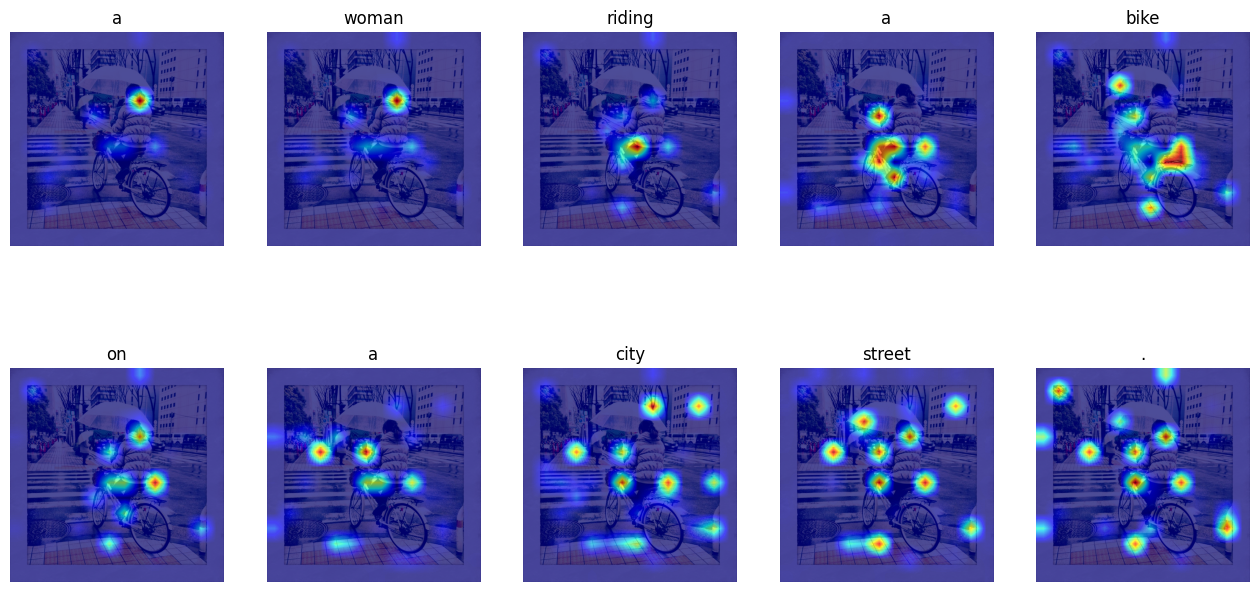

In [166]:
fig, ax = plt.subplots(ncols=5, nrows=2, figsize=(16, 8))
for i, idx in enumerate(token):
    attn_vector = weights[:, i, 1:]
    heat_map = torch.reshape(attn_vector, (14,14))
    heat_map -= torch.min(heat_map)
    heat_map /= torch.max(heat_map)
    heat_map = resize(heat_map.unsqueeze(0), [640,640]).squeeze(0).detach().cpu()
    heat_map = np.uint8(heat_map * 255)

    image = Image.open('/content/hw3_data/p3_data/images/bike.jpg').convert('RGB')
    ax[i//5][i%5].imshow(image)
    ax[i//5][i%5].set_title(idx)
    ax[i//5][i%5].imshow(heat_map, alpha=0.7, cmap='jet')
    ax[i//5][i%5].axis('off')

    print(i, idx)

In [26]:
print('weights: ', weights.shape)

weights:  torch.Size([1, 11, 197])


In [141]:
attn_vector = weights[:, 8, 1:]

In [142]:
attn_vector.shape

torch.Size([1, 196])

In [143]:
attn_map = torch.reshape(attn_vector, (14,14))
attn_map -= torch.min(attn_map)
attn_map /= torch.max(attn_map)

In [144]:
attn_map.unsqueeze(0).shape

torch.Size([1, 14, 14])

In [145]:
mask = resize(attn_map.unsqueeze(0), [640,640]).squeeze(0).detach().cpu()

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [146]:
 mask = np.uint8(mask * 255)

In [147]:
print(mask.shape)

(640, 640)


#### image

In [148]:
image = Image.open('/content/hw3_data/p3_data/images/bike.jpg').convert('RGB')
# Plot the original image
image.size

(640, 640)

In [149]:
image_array = np.array(image)

#### plt

In [ ]:
fig, ax = plt.subplots(ncols=5, nrows=3, figsize=(16, 8))

In [156]:
ax[1][3].imshow(image_array)
ax[1][3].set_title('street')
ax[1][3].imshow(mask, alpha=0.7, cmap='jet')
ax[0][2].axis('off')

(0.0, 1.0, 0.0, 1.0)

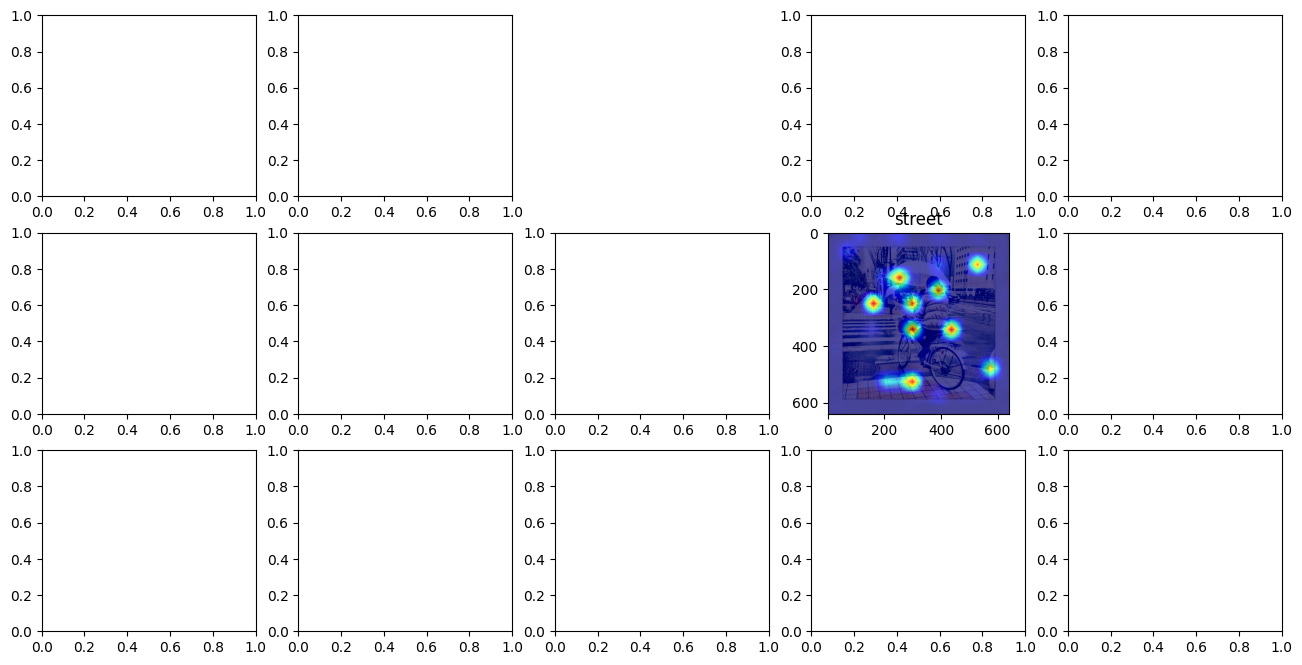

In [157]:
display(fig)